In [1]:
import glob
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import torch 
from torchvision.transforms import functional as F
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
import colorsys
import random

# Model Imports
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# To Do: 

* Train and Label Data
* Use masks to calculate compactness ratio 
* Move to python script
* Then apply model to rasberry pi by moving predict code to script.

In [ ]:
# packages for training the model
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

# pypi packages to install
pip install labelme2coco

pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [3]:
# New Imports
from engine import train_one_epoch, evaluate
import utils

import labelme2coco

In [4]:
!git clone https://github.com/thsant/wgisd.git

Cloning into 'wgisd'...
remote: Enumerating objects: 4248, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 4248 (delta 19), reused 820 (delta 7), pack-reused 3400
Receiving objects: 100% (4248/4248), 1.39 GiB | 42.94 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (1849/1849), done.


In [5]:
class GrapeDataset():
  def __init__(self, data_root, mode):

    self.mask_npz = sorted(glob.glob(os.path.join(data_root, "*.npz")))
    images_jpg = sorted(glob.glob(os.path.join(data_root, "*.jpg")))
    bbox_txt = sorted(glob.glob(os.path.join(data_root, "*.txt")))
    assert len(images_jpg) == len(bbox_txt)

    # In wgisd dataset not all masks are paired with bbox and imgs. 
    image_names = [os.path.splitext(os.path.basename(fp))[0] for fp in images_jpg]
    mask_names = [os.path.splitext(os.path.basename(fp))[0] for fp in self.mask_npz]
    removable_ind = [ii for ii, n in enumerate(image_names) if n not in mask_names]

    self.images_jpg, self.bbox_txt = list(), list()
    for ii in range(len(images_jpg)):
      if ii not in removable_ind:
        self.images_jpg.append(images_jpg[ii])
        self.bbox_txt.append(bbox_txt[ii])
    
    if mode == "train":
      print("Dataset in training mode")
      self.mask_npz = self.mask_npz[:100]
      self.images_jpg = self.images_jpg[:100]
      self.bbox_txt = self.bbox_txt[:100]
    elif mode == "valid":
      print("Dataset in evaluation mode")
      self.mask_npz = self.mask_npz[:34]
      self.images_jpg = self.images_jpg[:34]
      self.bbox_txt = self.bbox_txt[:34]
    else:
      raise ValueError("mode is an invalid value")
      
    # Checks on dataset
    assert len(self.images_jpg) == len(self.mask_npz) == len(self.bbox_txt)
    for ii in range(len(self.images_jpg)):
      assert os.path.splitext(os.path.basename(self.images_jpg[ii]))[0] == \
      os.path.splitext(os.path.basename(self.bbox_txt[ii]))[0] == \
      os.path.splitext(os.path.basename(self.mask_npz[ii]))[0]
    
    print("Dataset Passed Assertions")


  def __getitem__(self, idx):

    # Handle the img
    img = cv2.imread(self.images_jpg[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = F.to_tensor(img)

    # Handle the mask
    masks = np.load(self.mask_npz[idx])["arr_0"].astype(np.uint8)
    masks = np.moveaxis(masks, -1, 0)
    num_objs = masks.shape[0]
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    # Handle bboxes
    np_bbox_text = np.loadtxt(self.bbox_txt[idx], delimiter = " ", dtype = np.float32)
    bboxes = np_bbox_text[:, 1:]
    
    assert (bboxes.shape[0] == num_objs)

    _, height, width = img.shape
    scaled_boxes, areas = [], []
    for box in bboxes:
        x1 = box[0] - box[2]/2
        x2 = box[0] + box[2]/2
        y1 = box[1] - box[3]/2
        y2 = box[1] + box[3]/2
        scaled_boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        areas.append((x2 * width - x1 * width) * (y2 * height - y1 * height))

    
    scaled_boxes = torch.as_tensor(scaled_boxes, dtype=torch.float32)
    areas = torch.as_tensor(areas, dtype = torch.float32)

    #Create labels from masks
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {
            "boxes": scaled_boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": iscrowd
        }
    
    return img, target

  def __len__(self):
    return len(self.images_jpg)


In [16]:
train_batch_size = 2
valid_batch_size = 2

def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])

grape_Dataset_train = GrapeDataset("/content/wgisd/data", mode = "train")
grape_Dataset_valid = GrapeDataset("/content/wgisd/data", mode = "valid")
train_loader = torch.utils.data.DataLoader(grape_Dataset_train, batch_size = train_batch_size, shuffle = False, collate_fn = collate_fn)
valid_loader = torch.utils.data.DataLoader(grape_Dataset_valid, batch_size = valid_batch_size, shuffle = False, collate_fn = collate_fn)

Dataset in training mode
Dataset Passed Assertions
Dataset in evaluation mode
Dataset Passed Assertions


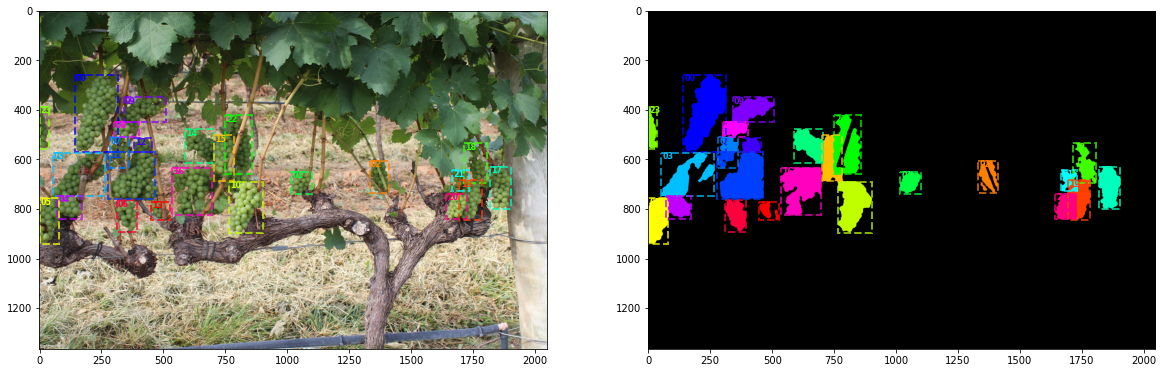

In [7]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

dataiter = iter(train_loader)
images, targets = next(dataiter)  
show_item(images[0].numpy(), targets[0]['boxes'].numpy(), targets[0]['masks'].numpy())

In [17]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained_backbone=True)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                  hidden_layer,
                                                  num_classes)

In [95]:
def train(model, train_loader, valid_loader, num_epochs):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)

  # Which params to freeze
  for param in model.backbone.parameters():
    param.requires_grad = False


  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

  for epoch in range(num_epochs):

      train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
      evaluate(model, valid_loader, device=device)

def save_model(model, epochs, save_path):
  model_info = {
      "model_state_dict": model.state_dict(), 
      "epochs": epochs}
  torch.save(model_info, save_path)
  print("Saved Model")

def load_model(path):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained_backbone=False)
  num_classes = 2

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)
  
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])

  return model

In [19]:
train(model, train_loader, valid_loader, 5)

Epoch: [0]  [ 0/50]  eta: 0:02:31  lr: 0.000021  loss: 3.5147 (3.5147)  loss_classifier: 0.7615 (0.7615)  loss_box_reg: 0.0521 (0.0521)  loss_mask: 1.9083 (1.9083)  loss_objectness: 0.6926 (0.6926)  loss_rpn_box_reg: 0.1002 (0.1002)  time: 3.0393  data: 2.6257  max mem: 4279
Epoch: [0]  [10/50]  eta: 0:01:31  lr: 0.000225  loss: 2.8736 (3.1261)  loss_classifier: 0.5568 (0.5701)  loss_box_reg: 0.2976 (0.3665)  loss_mask: 1.5367 (1.4166)  loss_objectness: 0.6683 (0.6556)  loss_rpn_box_reg: 0.0646 (0.1174)  time: 2.2992  data: 1.8899  max mem: 4279
Epoch: [0]  [20/50]  eta: 0:01:12  lr: 0.000429  loss: 2.6099 (2.7851)  loss_classifier: 0.4537 (0.5103)  loss_box_reg: 0.6122 (0.5629)  loss_mask: 0.7889 (1.0536)  loss_objectness: 0.5546 (0.5500)  loss_rpn_box_reg: 0.0848 (0.1082)  time: 2.3990  data: 1.9533  max mem: 4279
Epoch: [0]  [30/50]  eta: 0:00:49  lr: 0.000633  loss: 2.2497 (2.6119)  loss_classifier: 0.4153 (0.4781)  loss_box_reg: 0.7333 (0.6076)  loss_mask: 0.5989 (0.9037)  loss_ob

In [96]:
save_model(model, 5, "/content/prac_weights.pth")

Saved Model


In [99]:
net = load_model("/content/prac_weights.pth")

In [100]:
def get_model_out(model, img):

  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  assert type(img) == np.ndarray, "Only accepts numpy images"

  img = transforms.ToTensor()(img)
  img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  model.to(device)
  model.eval()

  out = model(img)

  return out

def run_model_img_path(model, img_path):

  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  out = get_model_out(model, img)
  return out

def plot_mask(out):
  image = np.zeros((out[0]["masks"].size(2), out[0]["masks"].size(3)))
  for mask_i in range(out[0]["masks"].size(0)):
    image += out[0]["masks"][mask_i, 0].cpu().detach().numpy()
  
  plt.imshow(image)

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/IMG_0458.JPEG"), cv2.COLOR_BGR2GRAY)

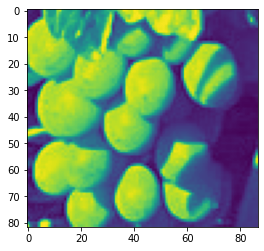

In [ ]:
plt.imshow(img)

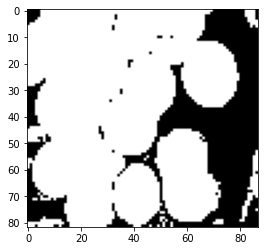

In [ ]:
img = cv2.cvtColor(cv2.imread("/content/IMG_0458.JPEG"), cv2.COLOR_BGR2GRAY)
output = img.copy()
ret, thresh = cv2.threshold(img,45,255,0)
plt.imshow(thresh, cmap = "gray")
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def find_cluster_ratio(thresh):
  thresh = thresh / 255.0
  print(thresh.sum())

In [ ]:
find_cluster_ratio(thresh)

5193.0
